Mounted at /content/drive


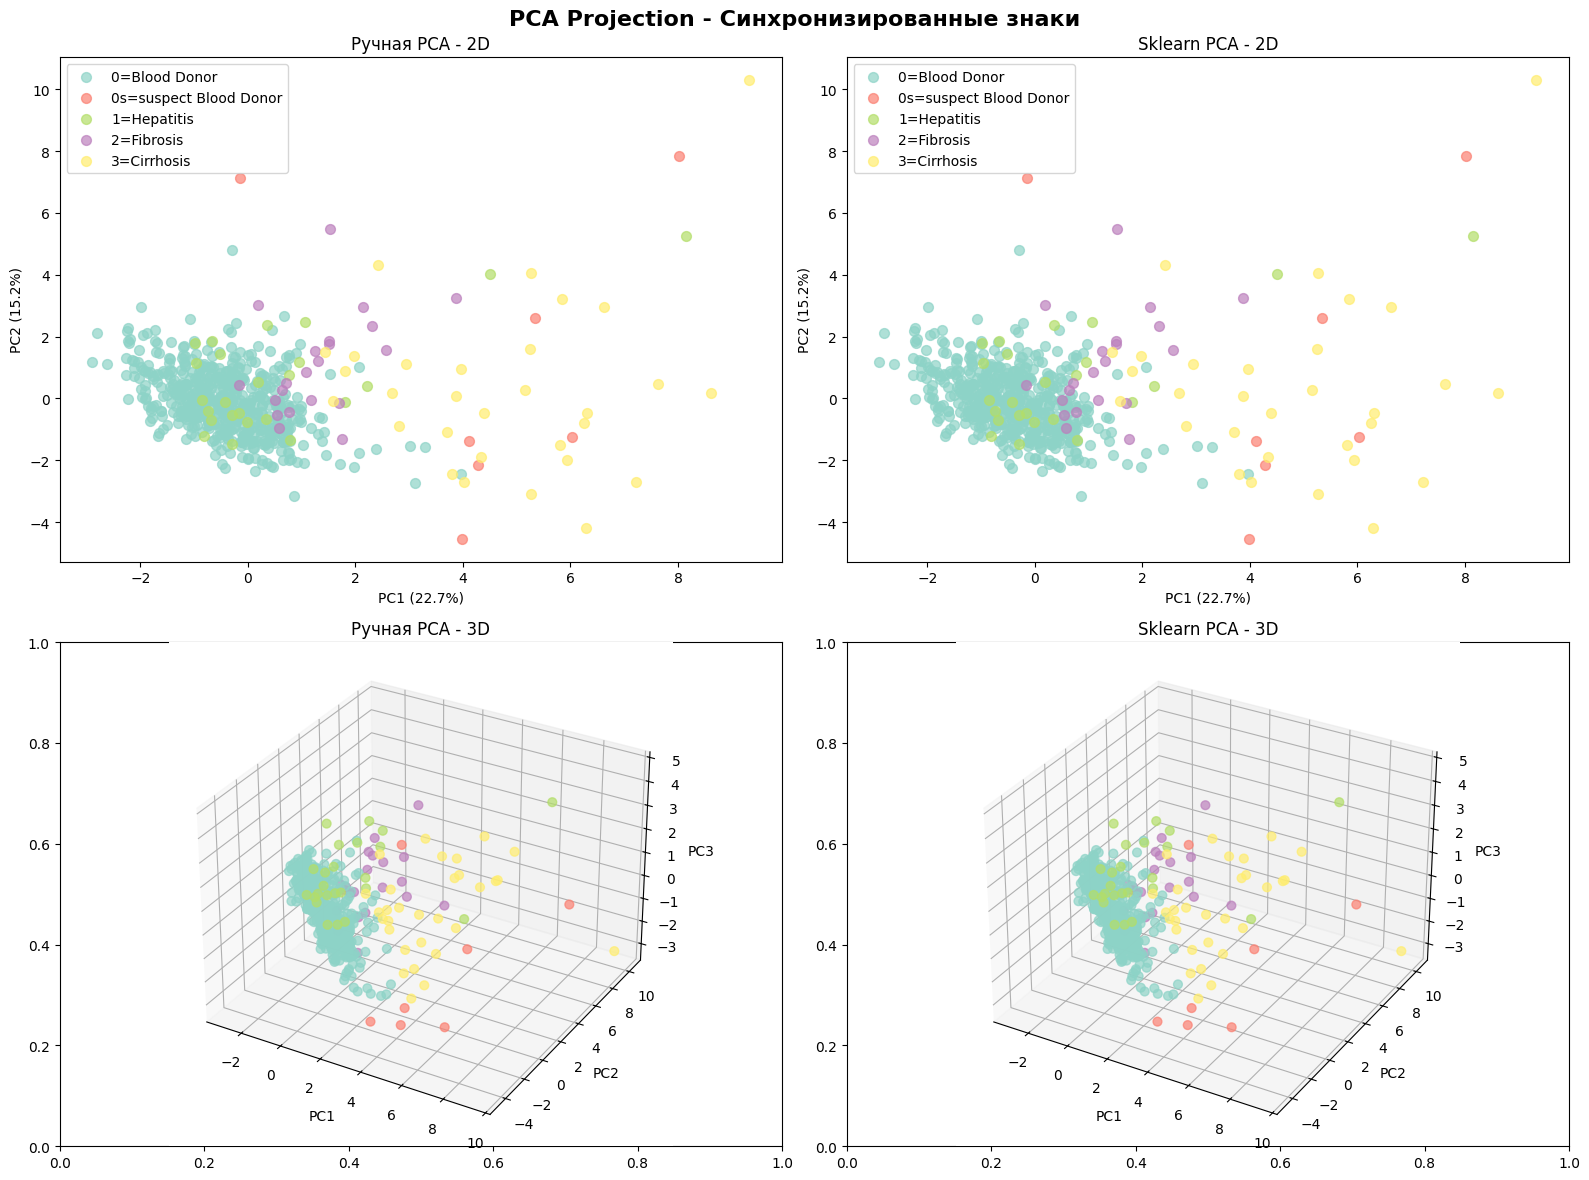

ПРОВЕРКА СИНХРОНИЗАЦИИ МЕТОДОВ:
PC1: Корреляция = 1.000000
     Дисперсия: ручная=0.2271, sklearn=0.2271
     Разница: 0.000000

PC2: Корреляция = 1.000000
     Дисперсия: ручная=0.1519, sklearn=0.1519
     Разница: 0.000000

PC3: Корреляция = 1.000000
     Дисперсия: ручная=0.1148, sklearn=0.1148
     Разница: 0.000000

ОБЪЯСНЕНИЕ РАЗЛИЧИЙ В ПРОЦЕНТАХ:
Sklearn объясненная дисперсия нормализована:
Сумма всех explained_variance_ratio_: 1.000000
Ручной метод - общая дисперсия: 12.019544
Проверка нормализации: 1.000000

Максимальная разница в дисперсии: 0.000000


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from google.colab import drive

drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/IAD/hcvdat0.csv')
y = data['Category']
X = data.drop('Category', axis=1)

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X.select_dtypes(include=[np.number]))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

cov_matrix = np.cov(X_scaled.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues_sorted = eigenvalues[sorted_indices]
eigenvectors_sorted = eigenvectors[:, sorted_indices]



X_pca_manual = X_scaled.dot(eigenvectors_sorted)

pca = PCA()
X_pca_sklearn = pca.fit_transform(X_scaled)

for i in range(X_pca_sklearn.shape[1]):
    correlation = np.corrcoef(X_pca_manual[:, i], X_pca_sklearn[:, i])[0, 1]

    if correlation < 0:
        X_pca_sklearn[:, i] = -X_pca_sklearn[:, i]
        pca.components_[i] = -pca.components_[i]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('PCA Projection - Синхронизированные знаки', fontsize=16, fontweight='bold')

unique_classes = np.unique(y_encoded)
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_classes)))

for i, class_idx in enumerate(unique_classes):
    mask = y_encoded == class_idx
    class_name = label_encoder.inverse_transform([class_idx])[0]

    axes[0, 0].scatter(X_pca_manual[mask, 0], X_pca_manual[mask, 1],
                      c=[colors[i]], label=class_name, alpha=0.7, s=50)

    axes[0, 1].scatter(X_pca_sklearn[mask, 0], X_pca_sklearn[mask, 1],
                      c=[colors[i]], label=class_name, alpha=0.7, s=50)

axes[0, 0].set_title('Ручная PCA - 2D')
axes[0, 0].set_xlabel(f'PC1 ({eigenvalues_sorted[0]/np.sum(eigenvalues_sorted)*100:.1f}%)')
axes[0, 0].set_ylabel(f'PC2 ({eigenvalues_sorted[1]/np.sum(eigenvalues_sorted)*100:.1f}%)')
axes[0, 0].legend()

axes[0, 1].set_title('Sklearn PCA - 2D')
axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[0, 1].legend()

ax1 = fig.add_subplot(2, 2, 3, projection='3d')
ax2 = fig.add_subplot(2, 2, 4, projection='3d')

for i, class_idx in enumerate(unique_classes):
    mask = y_encoded == class_idx
    class_name = label_encoder.inverse_transform([class_idx])[0]

    ax1.scatter(X_pca_manual[mask, 0], X_pca_manual[mask, 1], X_pca_manual[mask, 2],
               c=[colors[i]], label=class_name, alpha=0.7, s=40)

    ax2.scatter(X_pca_sklearn[mask, 0], X_pca_sklearn[mask, 1], X_pca_sklearn[mask, 2],
               c=[colors[i]], label=class_name, alpha=0.7, s=40)

ax1.set_title('Ручная PCA - 3D')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')

ax2.set_title('Sklearn PCA - 3D')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')

plt.tight_layout()
plt.show()

print("ПРОВЕРКА СИНХРОНИЗАЦИИ МЕТОДОВ:")
print("=" * 50)

for i in range(3):
    correlation = np.corrcoef(X_pca_manual[:, i], X_pca_sklearn[:, i])[0, 1]
    print(f"PC{i+1}: Корреляция = {correlation:.6f}")

    variance_manual = eigenvalues_sorted[i] / np.sum(eigenvalues_sorted)
    variance_sklearn = pca.explained_variance_ratio_[i]
    print(f"     Дисперсия: ручная={variance_manual:.4f}, sklearn={variance_sklearn:.4f}")
    print(f"     Разница: {abs(variance_manual - variance_sklearn):.6f}")
    print()


print("ОБЪЯСНЕНИЕ РАЗЛИЧИЙ В ПРОЦЕНТАХ:")
print("=" * 50)

print("Sklearn объясненная дисперсия нормализована:")
print(f"Сумма всех explained_variance_ratio_: {np.sum(pca.explained_variance_ratio_):.6f}")

total_variance_manual = np.sum(eigenvalues_sorted)
print(f"Ручной метод - общая дисперсия: {total_variance_manual:.6f}")
print(f"Проверка нормализации: {np.sum(eigenvalues_sorted/total_variance_manual):.6f}")

print(f"\nМаксимальная разница в дисперсии: {np.max(np.abs(eigenvalues_sorted/total_variance_manual - pca.explained_variance_ratio_)):.6f}")